<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/master/MLFit_OpenData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install probfit

In [0]:
import numpy as np
import pandas as pd
import probfit
import iminuit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')
print("Nuber of events: {}".format(len(data)))
print("Columns are:")
for col in data.columns:
  print("  {}".format(col))

Nuber of events: 100000
Columns are:
  Run
  Event
  type1
  E1
  px1
  py1
  pz1
  pt1
  eta1
  phi1
  Q1
  type2
  E2
  px2
  py2
  pz2
  pt2
  eta2
  phi2
  Q2
  M


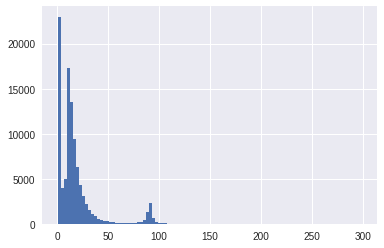

In [4]:
plt.hist(data.M, bins=100);

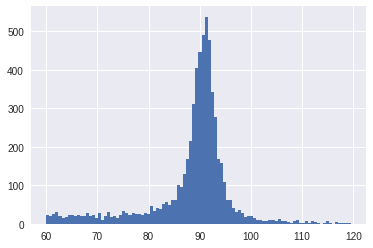

In [5]:
mass_range = (60., 120.)

data = data.loc[(data.M > mass_range[0]) & (data.M < mass_range[1])]

plt.hist(data.M, bins=100);

In [0]:
def SignalPDF(x, mass, sigma):
  return probfit.gaussian(x, mass, sigma)

def BgPDF(x, bg_slope):
  return bg_slope * np.exp(-bg_slope * x)

SignalPDF_n = probfit.Normalized(SignalPDF, mass_range)
BgPDF_n     = probfit.Normalized(BgPDF    , mass_range)

ModelPDF = probfit.AddPdfNorm(SignalPDF_n, BgPDF_n, facname=['fsig'])

In [0]:
likelihood = probfit.UnbinnedLH(ModelPDF, data.M.values)

In [11]:
print(iminuit.describe(likelihood))

['mass', 'sigma', 'bg_slope', 'fsig']


In [12]:
init_pars = dict(mass=90.,
                 sigma=5.,
                 bg_slope=1./60,
                 fsig=0.9)

minuit = iminuit.Minuit(likelihood, **init_pars)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter mass is floating but does not have initial step size. Assume 1.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter bg_slope is floating but does not have initial step size. Assume 1.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: InitialParamWarning: Parameter fsig is floating but does not have initial step size. Assume 1.
  


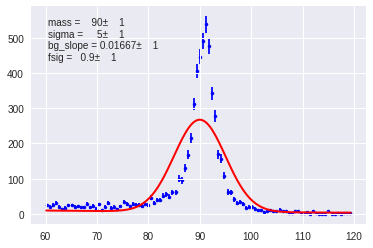

In [13]:
likelihood.draw(minuit=minuit);

In [15]:
minuit.migrad();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SmallIntegralWarning: (89.9557, -0.0814109198458509)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SmallIntegralWarning: (89.9557, 90.22880233142898, -2.6234332232616966)
  """Entry point for launching an IPython kernel.


FCN = 19274.33216287788 
 TOTAL NCALL = 147 
 NCALLS = 147 
 
 
 EDM = 1.9603947153092905e-07 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,90.7162,0.0427096,,,,,No
1,sigma,2.5042,0.0436834,,,,,No
2,bg_slope,0.0288679,0.00166155,,,,,No
3,fsig,0.739409,0.00725664,,,,,No


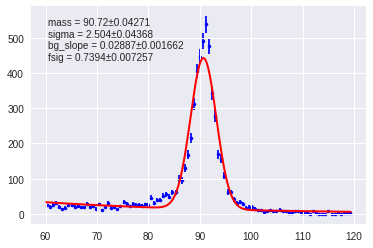

In [16]:
likelihood.draw(minuit=minuit);